In [2]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
import os
import seaborn.objects as so
from seaborn import axes_style
import gpplot
import numpy as np
from scipy import stats

In [3]:
plt.rcParams['font.size'] = 7
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

In [4]:
model_seq_info = pd.read_parquet('../data3/interim/model_seq_info.pq')
model_mat = pd.read_parquet('../data3/interim/defense_predictor_full_ft_mat.pq')

## GC content analysis

In [ ]:
%%time
refseq_gc = pd.read_csv('../data/interim/refseq_gc_content.csv', 
                        names=['assembly', 'genomic_locus', 'protein_id', 'start', 'end', 'strand', 'gc_frac', 'scaled_gc_frac', 'A_frac', 'C_frac', 'T_frac', 'G_frac', 'AA_frac', 'AC_frac', 'AT_frac', 'AG_frac', 'CA_frac', 'CC_frac', 'CT_frac', 'CG_frac', 'TA_frac', 'TC_frac', 'TT_frac', 'TG_frac', 'GA_frac', 'GC_frac', 'GT_frac', 'GG_frac', 'scaled_A_frac', 'scaled_C_frac', 'scaled_T_frac', 'scaled_G_frac', 'scaled_AA_frac', 'scaled_AC_frac', 'scaled_AT_frac', 'scaled_AG_frac', 'scaled_CA_frac', 'scaled_CC_frac', 'scaled_CT_frac', 'scaled_CG_frac', 'scaled_TA_frac', 'scaled_TC_frac', 'scaled_TT_frac', 'scaled_TG_frac', 'scaled_GA_frac', 'scaled_GC_frac', 'scaled_GT_frac', 'scaled_GG_frac']
                        )

In [ ]:
relevant_accessions = set(model_seq_info['product_accession'])

In [ ]:
%%time
filtered_refseq_gc = refseq_gc[refseq_gc['protein_id'].isin(relevant_accessions)].reset_index(drop=True)

In [34]:
filtered_refseq_gc['protein_context_id'] = (filtered_refseq_gc['protein_id'] + '|' + 
                                            filtered_refseq_gc['genomic_locus'] + '|' +
                                            filtered_refseq_gc['start'].astype(str) + '|' +
                                            filtered_refseq_gc['strand'])

In [37]:
merged_refseq_gc = (filtered_refseq_gc[['protein_context_id', 'gc_frac']]
                    .merge(model_seq_info, how='inner', on='protein_context_id')
                    .merge(model_mat, how='inner', left_on='seq_id', right_index=True))

In [43]:
gc_0_series = merged_refseq_gc['gc_frac']
esm_0_df = merged_refseq_gc.loc[:, merged_refseq_gc.columns.str.contains('ft[0-9]+_0')]

In [44]:
correlations = esm_0_df.corrwith(gc_0_series)
most_correlated_col = correlations.idxmax()
most_correlated_col

'ft626_0'

In [45]:
stats.pearsonr(gc_0_series, esm_0_df[most_correlated_col])

PearsonRResult(statistic=0.8041328997266367, pvalue=0.0)

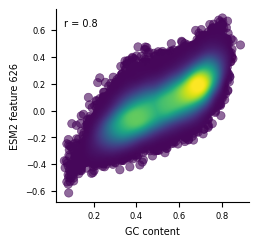

In [48]:
plt.subplots(figsize=(2.5, 2.5))
gpplot.point_densityplot(merged_refseq_gc, x='gc_frac', y=most_correlated_col)
gpplot.add_correlation(merged_refseq_gc, x='gc_frac', y=most_correlated_col, fontfamily='Sans-Serif')
plt.xlabel('GC content')
plt.ylabel('ESM2 feature 626')
sns.despine()
plt.savefig('../figures/ESM2_gc.svg', bbox_inches='tight', dpi=300)

In [49]:
del refseq_gc

## End GC content analysis

In [5]:
defense_predictions = pd.read_parquet('../data3/interim/cv_predictions_defense_predictor.pq')

In [6]:
%%time
seq_neighbors = pd.read_parquet('../data3/interim/model_neighbors_seq_ids.pq').reset_index()
df_homolog_df = pd.read_parquet('../data/interim/defense_finder_homologs_profile_names.pq')
seq_names = pd.read_parquet('../data/interim/seq_id_names.pq')

CPU times: user 32.4 s, sys: 12.1 s, total: 44.5 s
Wall time: 47.8 s


In [7]:
model_mat_y = model_mat.merge(model_seq_info.set_index('seq_id')[['defensive']], 
                              how='inner', left_index=True, right_index=True)

In [8]:
defensive_counts = (model_mat_y['defensive']
                    .value_counts()
                    .reset_index())
defensive_counts['name'] = defensive_counts.apply(lambda row: f"Defensive (n={str(row['count'])})" if row['defensive'] else f"Control (n={str(row['count'])})", 
                                                  axis=1)

In [9]:
merged_model_mat = (model_mat_y.merge(defensive_counts, how='inner', on='defensive'))

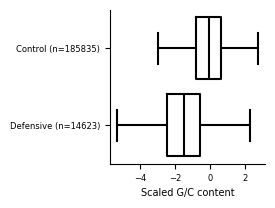

In [10]:
plt.subplots(figsize=(2,2))
ax = sns.boxplot(data=merged_model_mat, x='scaled_gc_frac_0', y='name', 
                 color='black', fill=False, orient='h', showfliers=False)
sns.despine()
plt.xlabel('Scaled G/C content')
plt.ylabel('')
plt.savefig('../figures/scaled_gc.svg', dpi=300, bbox_inches='tight')

In [11]:
merged_model_mat.groupby('defensive').agg({'scaled_gc_frac_0': ['mean', 'std', 'count']})

scaled_gc_frac_0                  
                      mean       std   count
defensive                                   
False            -0.156656  1.188518  185835
True             -1.538768  1.494035   14623

## Skip if SHAP values have already been calculated

In [11]:
shap_list = list()

In [12]:
%%time
for test_fold, test_fold_df in model_seq_info.groupby('test_fold'):
    print(test_fold)
    dp = load(f"../models3/beaker_fold_{str(test_fold)}.pkl")
    explainer = shap.TreeExplainer(dp)
    curr_X = model_mat.loc[test_fold_df['seq_id'], :]
    shap_values = explainer(curr_X)
    shap_value_df = pd.DataFrame(shap_values.values[:, :, 1])
    shap_value_df.index = curr_X.index
    shap_value_df.columns = curr_X.columns
    shap_list.append(shap_value_df)

0
1
2
3
4
CPU times: user 9h 17min 17s, sys: 13 s, total: 9h 17min 30s
Wall time: 12min 47s


In [13]:
cat_shap_value_df = pd.concat(shap_list)

In [14]:
cat_shap_value_df.to_parquet('../data3/interim/model_seq_shap.pq', index=True)

In [15]:
cat_shap_value_df = pd.read_parquet('../data3/interim/model_seq_shap.pq')

In [20]:
long_shap = (cat_shap_value_df.melt(ignore_index=False, 
                                    value_name='shap_value', var_name='feature')
             .reset_index()
             .set_index(['center_seq_id', 'feature']))

In [21]:
long_X = (model_mat.melt(ignore_index=False, 
                         value_name='feature_value', var_name='feature')
          .reset_index()
          .set_index(['center_seq_id', 'feature']))

In [22]:
merged_shap = long_shap.merge(long_X, left_index=True, right_index=True, how='inner')

In [23]:
del long_X, long_shap

In [24]:
merged_shap.to_parquet('../data3/interim/model_seq_seq_shap_x.pq', index=True)

## End skip

In [12]:
%%time
merged_shap = pd.read_parquet('../data3/interim/model_seq_seq_shap_x.pq')

CPU times: user 5min 41s, sys: 2min 5s, total: 7min 47s
Wall time: 5min 27s


## Skip again

In [25]:
merged_predictions = (model_seq_info.merge(defense_predictions, how='inner', on='seq_id'))

In [26]:
tp_ids = merged_predictions.loc[merged_predictions['defensive'] & 
                                (merged_predictions['prediction'] > 0.5), 
                                'seq_id']

In [27]:
len(tp_ids)/merged_predictions['defensive'].sum()

0.704848526294194

In [28]:
len(tp_ids)

10307

In [29]:
%%time
tp_shap = merged_shap.reset_index(level=1).loc[tp_ids, :]

CPU times: user 4min 25s, sys: 2min 52s, total: 7min 17s
Wall time: 7min 17s


In [30]:
tp_shap.to_parquet('../data3/interim/model_seq_tp_shap_x.pq', index=True)

## End skip again

In [13]:
tp_shap = pd.read_parquet('../data3/interim/model_seq_tp_shap_x.pq')

In [14]:
tp_shap_annot = (tp_shap.reset_index()
                 .merge(model_seq_info
                        .rename(columns={'seq_id': 'center_seq_id'}),
                        how='inner', on='center_seq_id'))

In [15]:
tp_exchange_agg_shap = (tp_shap_annot.groupby(['functional_group', 'feature'])
                        .agg(mean_shap=('shap_value', 'mean'), 
                             n=('center_seq_id', 'count'))
                        .reset_index())

In [16]:
tp_exchange_agg_shap['functional_group'].nunique()

316

In [17]:
def assign_feature(name):
    if 'scaled' in name:
        return 'nucleotide'
    if 'ft' in name:
        return 'ESM2'
    if 'len' in name:
        return 'length'
    if 'dist' in name:
        return 'dist'
    if 'co_directional' in name:
        return 'strand'

In [18]:
tp_shap_summary = (tp_exchange_agg_shap.groupby('feature')
                   .agg(mean_shap=('mean_shap', 'mean'))
                   .reset_index()
                   .sort_values('mean_shap', ascending=False))
tp_shap_summary['category'] = tp_shap_summary['feature'].apply(assign_feature)
tp_shap_summary['position'] = [int(x[-1]) if (':' not in x[-1]) else None for x in tp_shap_summary['feature'].str.split('_')]

In [19]:
tp_shap_summary.head(20)

,feature,mean_shap,category,position
846,ft251_0,0.858138,ESM2,0.0
851,ft252_0,0.709456,ESM2,0.0
2526,ft554_0,0.597579,ESM2,0.0
3316,scaled_gc_frac_0,0.437236,nucleotide,0.0
2711,ft588_0,0.408312,ESM2,0.0
696,ft224_0,0.396563,ESM2,0.0
3096,ft7_0,0.388258,ESM2,0.0
876,ft257_0,0.325311,ESM2,0.0
256,ft145_0,0.319944,ESM2,0.0
2256,ft505_0,0.278091,ESM2,0.0


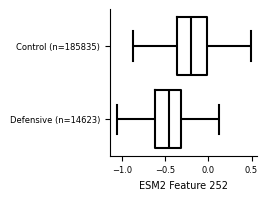

In [20]:
plt.subplots(figsize=(1.9,1.9))
ax = sns.boxplot(data=merged_model_mat, x='ft252_0', y='name', 
                 color='black', fill=False, orient='h', showfliers=False)
sns.despine()
plt.xlabel('ESM2 Feature 252')
plt.ylabel('')
plt.savefig('../figures/esm2_252.svg', dpi=300, bbox_inches='tight')

In [21]:
tp_category_summary = (tp_shap_summary.groupby(['position', 'category'])
                       .agg(sum_shap=('mean_shap', 'sum'))
                       .reset_index())
tp_category_summary['category'] = pd.Categorical(tp_category_summary['category'], 
                                                    categories=['ESM2', 'nucleotide', 
                                                                 'length', 'dist', 'strand'])
tp_category_summary['position'] = pd.Categorical(tp_category_summary['position'])
tp_category_summary['absolute_position'] = tp_category_summary['position'].astype(int).abs()

In [22]:
tp_category_summary.sort_values('sum_shap', ascending=False)

,position,category,sum_shap,absolute_position
8,0.0,ESM2,12.054824,0
12,1.0,ESM2,1.374916,1
4,-1.0,ESM2,1.311822,1
10,0.0,nucleotide,0.840969,0
16,2.0,ESM2,0.442979,2
0,-2.0,ESM2,0.434099,2
9,0.0,length,0.119487,0
6,-1.0,nucleotide,0.030897,1
14,1.0,nucleotide,0.025749,1
5,-1.0,length,0.014318,1


In [23]:
tp_category_summary.groupby(['absolute_position', 'category']).agg({'sum_shap': ['mean', 'count']})

sum_shap      
                                   mean count
absolute_position category                   
0                 ESM2        12.054824     1
                  nucleotide   0.840969     1
                  length       0.119487     1
                  dist              NaN     0
                  strand       0.000000     1
1                 ESM2         1.343369     2
                  nucleotide   0.028323     2
                  length       0.013454     2
                  dist              NaN     0
                  strand       0.003688     2
2                 ESM2         0.438539     2
                  nucleotide   0.001608     2
                  length       0.001268     2
                  dist              NaN     0
                  strand      -0.000033     2

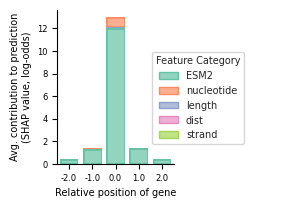

In [24]:
fig, ax = plt.subplots(figsize=(1.5,2))
(
    so.Plot(tp_category_summary.rename(columns={'category': 'Feature Category'}), 
            x='position', y='sum_shap', color='Feature Category')
    .add(so.Bar(), so.Stack())
    .on(ax)
    .theme({**axes_style("white"), 'legend.fontsize': 7, 'legend.title_fontsize': 7})
    .label(y='Avg. contribution to prediction\n(SHAP value, log-odds)', 
           x='Relative position of gene')
    .scale(color='Set2')
    .plot()
)
sns.despine(fig)
plt.savefig('../figures/category_feature_importance_test_tp.svg', dpi=300, bbox_inches='tight')

In [25]:
%%time
gc_X_shap = merged_shap.xs('scaled_gc_frac_0', level='feature')

CPU times: user 745 ms, sys: 112 ms, total: 857 ms
Wall time: 924 ms


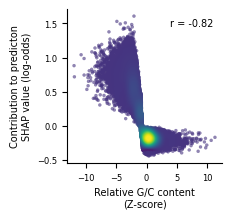

In [26]:
plt.subplots(figsize=(2,2))
gpplot.point_densityplot(data=gc_X_shap, x='feature_value', y='shap_value', s=5)
gpplot.add_correlation(data=gc_X_shap, x='feature_value', y='shap_value', loc='upper right', fontfamily='sans-serif')
plt.ylabel('Contribution to predicton\nSHAP value (log-odds)')
plt.xlabel('Relative G/C content\n(Z-score)')
sns.despine()
plt.savefig('../figures/gc_content_shap.svg', dpi=300, bbox_inches='tight', )

In [28]:
tp_shap_summary.to_parquet('../data3/interim/agg_feature_shap_values.pq', index=False)

## Get neighbor importance

In [29]:
del tp_shap, tp_shap_annot, gc_X_shap

In [30]:
feature_mapping = (tp_shap_summary[['feature', 'position', 'category']]
                   .set_index('feature'))

## Start skip

In [46]:
%%time
per_seq_importance = (merged_shap.reset_index(level=0)
                      .merge(feature_mapping, how='inner', left_index=True, right_index=True)
                      .groupby(['center_seq_id', 'position'])
                      .agg(sum_shap=('shap_value', 'sum'))
                      .reset_index()
                      .rename(columns={'position': 'relative_position'}))
per_seq_importance['absolute_position'] = per_seq_importance['relative_position'].abs()

CPU times: user 4min 54s, sys: 1min 9s, total: 6min 4s
Wall time: 6min 5s


In [47]:
per_seq_importance.to_parquet('../data3/interim/model_neighbor_importance.pq', index=False)

## End skip

In [31]:
per_seq_importance = pd.read_parquet('../data3/interim/model_neighbor_importance.pq')

In [32]:
merged_per_seq_importance = (per_seq_importance
                             .merge(seq_neighbors, how='inner', 
                                    on=['center_seq_id', 'relative_position']))

In [33]:
unique_names = seq_names['name'].drop_duplicates()

In [34]:
merged_per_seq_importance['defense_homolog'] = merged_per_seq_importance['seq_id'].isin(df_homolog_df['seq_id'])
(merged_per_seq_importance.groupby(['absolute_position', 'defense_homolog'])
 .agg(n=('seq_id', 'count'), 
      avg_shap=('sum_shap', 'mean')))

n  avg_shap
absolute_position defense_homolog                  
0.0               False            179297 -0.566911
                  True              21161  9.360683
1.0               False            346233 -0.053665
                  True              24614  1.368199
2.0               False            341864 -0.010937
                  True              21648  0.568963

In [35]:
integrase_regex = 'integrase'
integrase_names = unique_names[unique_names.str.contains(integrase_regex)]
integrase_seq_ids = seq_names.loc[seq_names['name'].isin(integrase_names), 'seq_id']

In [36]:
merged_per_seq_importance['integrase'] = merged_per_seq_importance['seq_id'].isin(integrase_seq_ids)
(merged_per_seq_importance.groupby(['absolute_position', 'integrase'])
 .agg(n=('seq_id', 'count'), 
      avg_shap=('sum_shap', 'mean')))

n  avg_shap
absolute_position integrase                  
0.0               False      191503  0.545731
                  True         8955 -0.901534
1.0               False      368122  0.038034
                  True         2725  0.401974
2.0               False      361568  0.021744
                  True         1944  0.368335

In [37]:
transposase_regex = 'transposase'
transposase_names = unique_names[unique_names.str.contains(transposase_regex)]
transposase_seq_ids = seq_names.loc[seq_names['name'].isin(transposase_names), 'seq_id']

In [38]:
merged_per_seq_importance['transposase'] = merged_per_seq_importance['seq_id'].isin(transposase_seq_ids)
(merged_per_seq_importance.groupby(['absolute_position', 'transposase'])
 .agg(n=('seq_id', 'count'), 
      avg_shap=('sum_shap', 'mean')))

n  avg_shap
absolute_position transposase                  
0.0               False        191188  0.520200
                  True           9270 -0.325797
1.0               False        362907  0.029663
                  True           7940  0.545524
2.0               False        358297  0.017805
                  True           5215  0.421598

In [39]:
def assign_neighbor_type(row):
    if row['defense_homolog']:
        return 'defensive'
    elif row['integrase']:
        return 'integrase'
    elif row['transposase']:
        return 'transposase'
    else:
        return 'other'

In [40]:
merged_per_seq_importance['neighbor_type'] = merged_per_seq_importance.apply(assign_neighbor_type, axis=1)
neighbor_type_count = (merged_per_seq_importance.groupby(['neighbor_type', 'absolute_position'])
                       .agg(neighbor_type_n=('protein_context_id', 'count'))
                       .reset_index())
neighbor_type_count['display_neighbor_type'] = (neighbor_type_count['neighbor_type'] + 
                                               ' (n=' + 
                                               neighbor_type_count['neighbor_type_n'].astype(str) + 
                                               ')')
merged_per_seq_importance = (merged_per_seq_importance.merge(neighbor_type_count, how='inner', 
                                               on=['neighbor_type', 'absolute_position']))
merged_per_seq_importance['neighbor_type'] = pd.Categorical(merged_per_seq_importance['neighbor_type'],
                                                     categories=['other', 'integrase', 'transposase', 'defensive'])

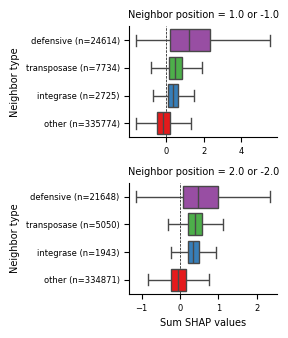

In [41]:
g = sns.FacetGrid(data=(merged_per_seq_importance
                        .query('absolute_position != 0')
                        .sort_values('neighbor_type', ascending=False)), 
                  row='absolute_position', sharey=False, sharex=False, height=1.7, 
                  aspect=1.7)
g.map_dataframe(sns.boxplot, y='display_neighbor_type', x='sum_shap', saturation=1, 
                hue='neighbor_type', palette='Set1', showfliers=False)
g.map(plt.axvline, x=0, linestyle='dashed', color='black', zorder=0, linewidth=0.5)
g.set_axis_labels(x_var='Sum SHAP values', y_var='Neighbor type')
g.set_titles(row_template='Neighbor position = {row_name} or -{row_name}')
plt.savefig('../figures/sum_shap_neighbor_type_box.svg', dpi=300, bbox_inches='tight')

In [44]:
seq_names

,name,seq_id
0,replication initiation protein,77138b13ef666db8aae0d9d2c800cec7c70ff4a38c2190...
1,internal scaffolding protein,7b1b1cf350d05237cac3630f50cb292d592a5534da3e5c...
2,hypothetical protein,2a394a7a97d9ac145a7ce7b0caa97bb3f72588340501c9...
3,DNA maturation protein,9cb64b6b04882f58b1dd32a3847b2e8ad59a5821320707...
4,external scaffolding protein,909b9a30743612fb74eac6ed8798f4175dd0cbc015d815...
...,...,...
66531284,putative lipoprotein YsaB,b7c375b849371d0489233a27b282850a4142d8228007bb...
66531285,putative PTS enzyme IIB component SgcB,a4b941582a3a812b4e262bd37a9f86e1830c1c1ef394ea...
66531286,toxin of the TopAI-YjhQ toxin-antitoxin system...,1ad860fe89cf8dbc0b6399c5886c7276379ab9ebf518ce...
66531287,DUF1435 domain-containing protein YjjZ,03bdf3f434a6fe5f45fe7de60862bbd0792422bfa006dd...


In [47]:
name_seq_importance = (merged_per_seq_importance
                       .query('relative_position != 0')
                       .merge(seq_names, how='inner', on='seq_id')
                       .query("name != 'hypothetical protein'")
                       .groupby(['name', 'absolute_position'])
                       .agg(total_seqs=('seq_id', 'count'), 
                            sum_shap=('sum_shap', 'sum'), 
                            mean_sum_shap=('sum_shap', 'mean'), 
                            std_sum_shap=('sum_shap', 'std'))
                       .sort_values('sum_shap', ascending=False))

In [50]:
name_seq_importance.to_parquet('../data3/interim/agg_shap_name_importance.pq', index=True)

In [48]:
name_seq_importance.head(10)

,,total_seqs,sum_shap,mean_sum_shap,std_sum_shap
name,absolute_position,,,,
AAA family ATPase,1.0,1893,2705.677760,1.429307,1.358921
transposase,1.0,2644,1393.547332,0.527060,0.544967
DEAD/DEAH box helicase,1.0,649,964.758542,1.486531,1.469855
RAMP superfamily CRISPR-associated protein,1.0,271,956.747817,3.530435,0.861326
ATP-binding protein,1.0,2864,948.576057,0.331207,1.229956
AAA family ATPase,2.0,1472,900.433695,0.611708,0.562695
transposase,2.0,1665,671.049841,0.403033,0.316322
DEAD/DEAH box helicase family protein,1.0,275,628.803991,2.286560,0.887550
tyrosine-type recombinase/integrase,1.0,1208,496.388285,0.410917,0.375370


## Directionality analysis

In [42]:
direction_info = (model_mat.loc[:, model_mat.columns.isin(['co_directional_-2', 
                                                          'co_directional_-1', 
                                                          'co_directional_1', 
                                                          'co_directional_2'])]
                  .melt(ignore_index=False, var_name='feature', value_name='co_directional')
                  .reset_index())
direction_info['relative_position'] = direction_info['feature'].str.split('_', expand=True)[2].astype(int)
direction_info = direction_info.drop(columns='feature')

In [66]:
dist_info = (model_mat.loc[:, model_mat.columns.isin(['dist_-1:0', 'dist_0:1'])]
             .melt(ignore_index=False, var_name='feature', value_name='dist')
             .reset_index())
dist_info['relative_position'] = dist_info['feature'].map({'dist_-1:0': -1, 
                                                           'dist_0:1': 1})
dist_info = dist_info.drop(columns='feature')

In [68]:
merged_direction_dist_info = (merged_per_seq_importance.merge(direction_info, how='inner', on=['center_seq_id', 'relative_position'])
                              .merge(dist_info, on=['center_seq_id', 'relative_position']))
merged_direction_dist_info['TU'] = (merged_direction_dist_info['co_directional'].astype(bool) & 
                                    (merged_direction_dist_info['dist'] < 100))

In [70]:
(merged_direction_dist_info.groupby(['defense_homolog','TU'])
 .agg({'center_seq_id': 'count', 
       'sum_shap': 'median'}))

center_seq_id  sum_shap
defense_homolog TU                            
False           False         205504 -0.139600
                True          140729 -0.153368
True            False           9764  0.583465
                True           14850  1.695027

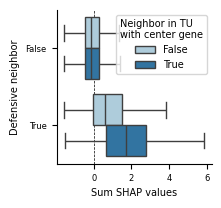

In [71]:
plt.subplots(figsize=(2, 2))
sns.boxplot(data=merged_direction_dist_info, y='defense_homolog', 
            x='sum_shap', hue='TU', palette='Paired', showfliers=False, orient='h')
plt.axvline(x=0, linestyle='dashed', color='black', linewidth=0.5, zorder=0)
plt.xlabel('Sum SHAP values')
plt.ylabel('Defensive neighbor')
plt.legend(title='Neighbor in TU\nwith center gene')
sns.despine()
plt.savefig('../figures/sum_shap_tu_box.svg', dpi=300, bbox_inches='tight')